# Score Matching Introduction

Let $\mathcal{D}$ be a distribution over $\mathbb{R}^n$ with probability density function (PDF) $p: \mathbb{R}^n \to \mathbb{R}$. One way of modeling $\mathcal{D}$ is via its score function $s: \mathbb{R}^n \to \mathbb{R}^n$ defined as
$$ s(z) = \nabla_z \log p(z)$$

In practice, we may have access to $\mathcal{D}$ via a finite set of samples and don't know its PDF or score function. One simple way to produce a PDF from a discrete set of samples is via radial basis function (RBF) interpolation. For $\sigma \in \mathbb{R}^+$ define the RBF kernel as
$$ K_{\sigma}(x,z) = \textrm{exp}\left(\frac{-\lVert x-z\rVert_2^2}{2\sigma^2}\right)$$

Then the interpolated score function $s_\sigma$ for $\mathcal{D}$ is
$$ s_\sigma(z, \mathcal{D}) = \frac{\mathbb{E}_{x \sim \mathcal{D}}\left[(x-z)K_{\sigma}(x,z)\right]}{\mathbb{E}_{x \sim \mathcal{D}}\left[K_{\sigma}(x,z)\right]}$$

Given a dataset $\mathcal{D}$, the interpolated score function defines a vector field describing a soft projection of arbitrary vectors onto $\mathcal{D}$.

## Task 1: compute and display interpolated score function for a dataset

We define a simple distribution over $\mathbb{R}^2$ - uniform over a spiral - and we sample 20 points from the distribution. The task is to generate a grid of points in $\mathbb{R}^2$ and compute the interpolated score function at each point. Then call the provided plotting code to recreate the following figure:




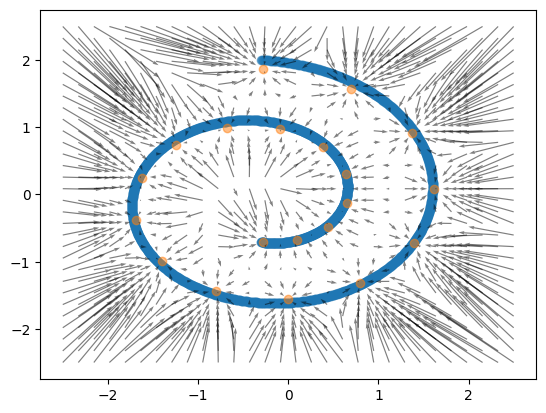


Implement the following functions:


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# dataset generator
def spiral2d(N=100, random = False, shift=None):
    """Samples N points from a spiral centered at `shift` (or the origin if `shift` is None)"""
    time_steps = torch.rand(N) if random else torch.linspace(0, 1, N)
    t = (3 * torch.pi / 2) * (1 + 2 * time_steps)
    data = torch.stack(
        [t * torch.cos(t), t * torch.sin(t)], dim=1
    )

    data = (data - data.mean(dim=0, keepdims=True)) / data.std(dim=0, keepdims=True)

    # throw the data in a some arbitrary direction
    if shift is not None:
        data = data +  shift

    return data

# plotting helper function
def plot_vectors(z, score, **quiver_kwargs):
    """Plots vector field given by direction vectors `score` at points `z` of R^2"""
    all_lims = torch.stack((z.min(0).values, z.max(0).values, (z+score).min(0).values, (z+score).max(0).values), dim=0)
    mins = all_lims.min(0).values
    maxs = all_lims.max(0).values

    x, y = z.T
    score_x, score_y = score.T
    qargs = dict(angles='xy', scale_units='xy', scale=1, alpha=0.5)
    qargs.update(quiver_kwargs)
    plt.quiver(x, y, score_x, score_y, **qargs)

# generate and plot spiral data
true_dist = spiral2d(N=2000)
dataset = spiral2d(N=20)

In [82]:
# np.exp(np.log(5*3))


15.0

In [95]:
import math
import numpy as np
import torch

def get_grid(x_lim=(-2.5,2.5), y_lim=(-2.5,2.5), nx=100, ny=100):
  """Produces an even grid of nx by ny points in R^2,
  from x_lim[0] to x_lim[1] along x axis, and y_lim[0] to y_lim[1] along y axis

  Returns tensor of shape (nx*ny, 2)
  """
  r = []
  for x in np.linspace(x_lim[0], x_lim[1], nx):
    for y in np.linspace(y_lim[0], y_lim[1], ny):
      r.append([x,y])
  return torch.tensor(r)

def rbf_score(z, data, sigma=0.2):
    """ Estimates the interpolated score function for data against inputs z
    
    Params:
    z: a tensor of shape (...,2) giving inputs to the score function
    data: a tensor of shape (N,2) giving the dataset whose interpolated score function we estimate
    sigma: the parameter of the RBF kernel
    
    Returns:
    a tensor of the same shape as x giving the interpolated score function evaluated at z
    """
    x = data
    z.shape # (1000,2)
    x.shape # (20,2)
    diff = x[:,None,:] - z # (10000,20,2)
    sq_dist = (diff**2).sum(-1) # (20,10000)
    # return -sq_dist / (2 * sigma**2)

    # weight = torch.exp(-sq_dist / (2 * sigma**2)) # (20,10000)
    # numer = (diff * weight[:, :, None]).mean(0) # (10000,2)
    # denom = weight.mean(0)[:, None]
    # score = numer / denom

    log_weight = -sq_dist / (2 * sigma**2)
    log_numer = torch.log(diff) + log_weight[:,:,None]
    return diff
    n = log_weight.shape[0]
    log_denom = torch.logsumexp(log_weight, 0) / n
    score = log_numer - log_denom[:,None]
    return log_numer
    assert not np.isnan(score).any()
    # return torch.where(numer!=0, score, 0.0)  # when weight == 0 we get 0/0., should i do this in logspace?
    
    return score

rbf_score(grid, dataset, .06)

tensor([[[ 2.2202,  1.7990],
         [ 2.2202,  1.6265],
         [ 2.2202,  1.4541],
         ...,
         [-2.7798, -2.8562],
         [-2.7798, -3.0286],
         [-2.7798, -3.2010]],

        [[ 2.5929,  1.8169],
         [ 2.5929,  1.6445],
         [ 2.5929,  1.4720],
         ...,
         [-2.4071, -2.8383],
         [-2.4071, -3.0107],
         [-2.4071, -3.1831]],

        [[ 2.9383,  2.0156],
         [ 2.9383,  1.8431],
         [ 2.9383,  1.6707],
         ...,
         [-2.0617, -2.6396],
         [-2.0617, -2.8120],
         [-2.0617, -2.9844]],

        ...,

        [[ 3.8751,  3.4179],
         [ 3.8751,  3.2455],
         [ 3.8751,  3.0731],
         ...,
         [-1.1249, -1.2372],
         [-1.1249, -1.4096],
         [-1.1249, -1.5821]],

        [[ 3.1965,  4.0719],
         [ 3.1965,  3.8994],
         [ 3.1965,  3.7270],
         ...,
         [-1.8035, -0.5833],
         [-1.8035, -0.7557],
         [-1.8035, -0.9281]],

        [[ 2.2202,  4.3630],
       

In [64]:
def gaussian_kernel(x, z, sigma):
    exponent = -np.linalg.norm(x-z)**2 / (2 * sigma**2)
    return np.exp(exponent)

# Example usage with small sigma
x = np.array([1.0, 2.0, 3.0])
z = np.array([1.1, 2.1, 3.1])
sigma = 1e-3  # small sigma value

kernel_value = gaussian_kernel(x, z, sigma)

In [65]:
kernel_value

0.0

Now reproduce the plot by executing the following code:

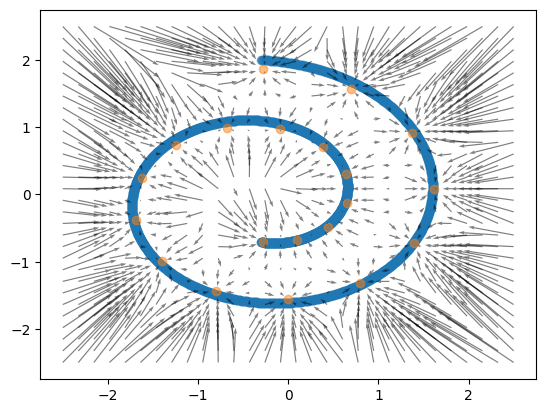

In [14]:
plt.scatter(*true_dist.T, alpha=0.5)
plt.scatter(*dataset.T, alpha=0.5)

# use solution code
grid = get_grid(nx=30,ny=30)
score = rbf_score(grid, dataset, sigma=0.2)
plot_vectors(grid.view(-1,2), score.view(-1,2), scale=2)

## Sampling via the score function

Given our interpolated score function estimate $s_\sigma$, we can now implement a sampling scheme. Specifically, we examine annealed Langevin dynamics: given $x_0$ from an arbitrary initial distribution (e.g., uniform over a grid), we define an update rule

$$
x_t = x_{t-1} + \lambda_t s_{\sigma_t}(x_{t-1}) + \sqrt{2\lambda_t}\epsilon_{t}
$$

where $\epsilon_t \sim \mathcal{N}(0,I)$ is Gaussian noise and $\lambda_t$ is an iteration-dependent step size. We anneal by taking decreasing $\sigma_t$ as $t$ increases.

We will use
- a log-linear schedule for $\sigma^2$ in $[10^{-4}, 2\times 10^{-2}]$
- $\lambda_t$ given by
$$ \lambda_t = \frac{1-\alpha_t}{\sqrt{\alpha_t(1-\bar\alpha_t)}}$$ where $\alpha = 1 - \sigma^2$ and $\bar\alpha_t = \prod^{t}_{i=1}\alpha_i$

## Task 2: Implement annealed Langevin dynamics sampler

Implement the following function:

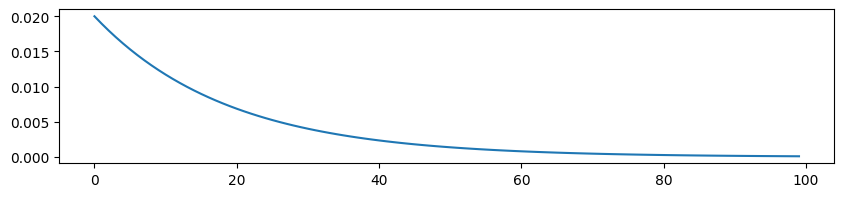

In [16]:
def log_linear_schedule(initial_value, final_value, steps):
  return torch.tensor(np.exp(np.linspace(np.log(initial_value), np.log(final_value), steps)))
fig, ax = plt.subplots(figsize=(10,2))
ax.plot(log_linear_schedule(2e-2, 1e-4, 100))

In [17]:
def sample(init_sample, score_function, n_steps, sigma_min=1e-4, sigma_max=2e-2, return_extra=False):
  """Samples from annealed Langevin dynamics for n_steps steps

  Params:
    init_sample: a tensor of shape (...,2) giving the initial data
    score_function: a function with two parameters, x and sigma, returning the estimated interpolated score function s_sigma(x)
    n_steps: the number of steps of of the dynamics to simulate
    sigma_min: minimum sigma value for annealing
    sigma_max: maximum sigma value for annealing

  Returns:
    a list of n_steps+1 tensors, whose entries are the results of the simulation starting from init_sample (first entry is init_sample)
  """
  n, d = init_sample.shape
  sigma_sq_t = log_linear_schedule(sigma_max, sigma_min, n_steps)
  alpha_t = 1-sigma_sq_t
  alpha_t_bar = alpha_t.cumprod(0)
  lambda_t = (1-alpha_t) / torch.sqrt(alpha_t*(1-alpha_t_bar))

  path = [init_sample]
  score_terms = []
  noise_terms = []
  for i in range(n_steps):
    score_term = lambda_t[i] * score_function(path[-1], sigma_sq_t[i]**.5)
    noise_term = torch.sqrt(2*lambda_t[i])*torch.randn((n,d))
    x_curr = path[-1] + score_term + noise_term
    path.append(x_curr)
    score_terms.append(score_term)
    noise_terms.append(noise_term)
  if return_extra:
    return path, score_terms, noise_terms, lambda_t
  return path

Visualize the results:

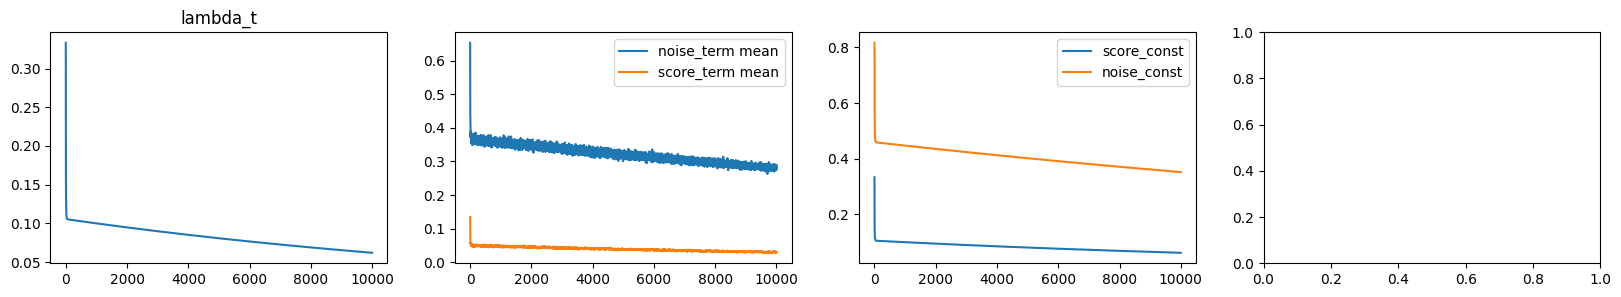

In [52]:
fig, axes = plt.subplots(1,4,figsize=(20,3))
path, score_terms, noise_terms, lambda_t = sample(grid, lambda x,sigma: rbf_score(x, dataset, sigma), n_steps=10000, sigma_min=0.06, sigma_max=0.1, return_extra=True)
axes[0].plot(lambda_t)
axes[0].set_title('lambda_t')
axes[1].plot(np.abs(np.array(noise_terms)).mean((1,2)), label='noise_term mean')
axes[1].plot(np.abs(np.array(score_terms)).mean((1,2)), label='score_term mean')
axes[1].legend()
axes[2].plot(lambda_t, label='score_const')
axes[2].plot(torch.sqrt(2*lambda_t), label='noise_const')
axes[2].legend()

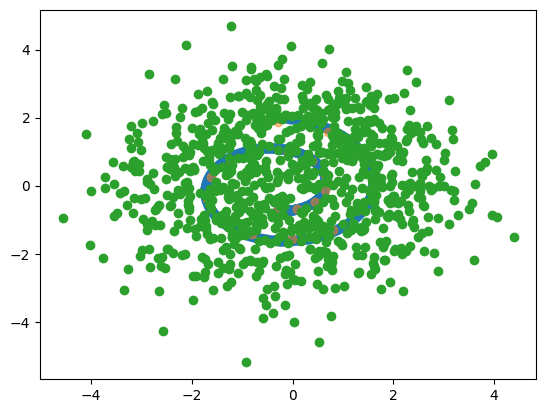

In [53]:
plt.scatter(*true_dist.T, alpha=0.5)
plt.scatter(*dataset.T, alpha=0.5)
plt.scatter(*path[-1].T)

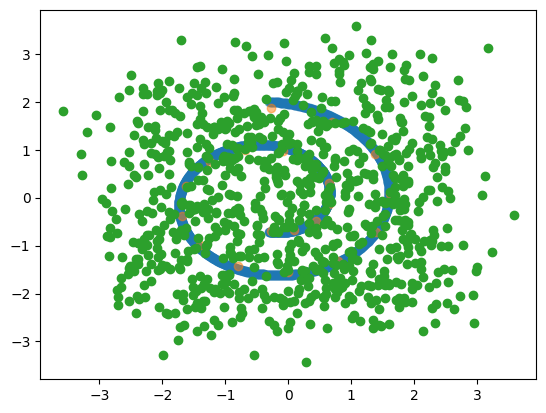

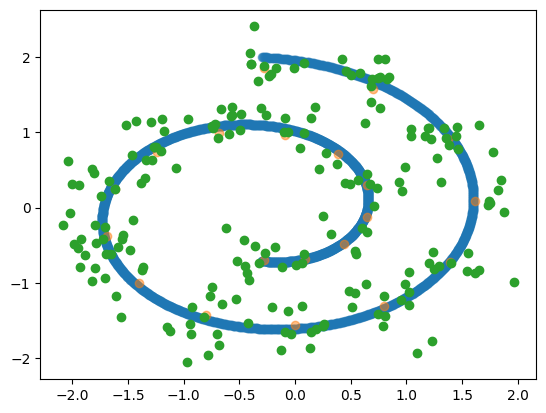

In [ ]:
path = sample(grid, lambda x,sigma: rbf_score(x, dataset, sigma), n_steps=10000, bmin=0.0001, bmax=0.02)
plt.scatter(*true_dist.T, alpha=0.5)
plt.scatter(*dataset.T, alpha=0.5)
plt.scatter(*path[-1].T)

## Simplified score matching

Instead of using the explicit expression for the interpolated score function, we could attempt to learn a score function via a simplified version of denoising score matching. Given $x \sim \mathcal{D}$, we perturb it with Gaussian noise and learn to predict the original vector $x$ (or equivalently, the perturbation). That is, we can parameterize a model $f_\theta$ with parameters $\theta$, and optimize it according to the objective

$$ \min_\theta \mathbb{E}_{x,\epsilon,\sigma}\left[\|f_\theta(x+\sigma\epsilon, \sigma)-\sigma\epsilon\|^2_2\right] $$

Here, $x \sim \mathcal{D}$ and $\epsilon \sim \mathcal{N}(0,I)$ and $\sigma$ is drawn from a log-uniform distribution corresponding to the log-linear sampling schedule.

## Task 3: Training a neural network via score matching

Define a simple neural network architecture taking as inputs the noised samples $x+\sigma\epsilon$ and the noise rate $\sigma$, and predicting $\sigma\epsilon$. Train it by optimizing the simplified denoising score matching objective.